# **Custos Médicos - Combinação de Modelos**

A ideia neste problema é estimar o custo do seguro no plano de saúde para uma pessoa com base em dados adicionais como idade, se é fumante ou não, se tem dependentes, etc.

Isto quer dizer que temos considerar que nuestra variável dependiente será o **_Custo_** e as caraterísticas restantes serão consideradas como as variáveis independientes, em outras palavras o **Custo** depende (umas vezes mais e outras menos) de todas as outras variáveis

O Primeiro a fazer é estabelecer a influencia de todas essas variáveis (caraterísticas) no valor final dos Custos Médicos, de forma individual.

**_É importante lembrar que temos que ter a capacidade de predecir um valor de custo para uma nova pessoa (cliente) com base as suas proprias caraterísticas_.**

Iniciemos esta análise selecionando os dados que vamos a utilizar.


# Importação dos dados:
Os dados podem ser obtido do site do Kaggle.com : https://www.kaggle.com/datasets/mirichoi0218/insurance

Podemos fazer um download e depois abrir ou também importar diretamente usando um link onde esta o arquivo. Esses dados serão guardados na variável **dados** do tipo _dataframe_.

In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/profjuanito/Dataset/main/insurance.csv'
dados = pd.read_csv(url)
dados.head()

# Informações dos dados e Mise en place:

Obter informações gerais dos dados como número de variáveis, tipo, etc. Os comandos podem ser visualizados e entendidos melhor nos anteriores scripts (Custos_Medicos.ipynb, etc)

Lembrar o que foi feito nos modelos anteriores:

* Transformar a variável **Fumante** em 0 (não) ou 1 (sim)
* Colocar a variável resposta na escala para cada mil dolares.

Nesta análise também vamos considerar só as variáveis:
* var. dependiente: **Custos**
* var. independientes: indice de massa corporal (**IMC**) e ser fumante ou não.

In [ ]:
# mise un place
dados['smoker'] = dados['smoker'].map({'yes': 1, 'no': 0})
dados['charges'] = dados['charges']/1000 
dados['sex'] = dados['sex'].map({'male': 1, 'female': 0})

dados = dados[['age', 'bmi', 'smoker','sex', 'charges']]
dados.head()

,age,bmi,smoker,sex,charges
0,19,27.900,1,0,16.884924
1,18,33.770,0,1,1.725552
2,28,33.000,0,1,4.449462
3,33,22.705,0,1,21.984471
4,32,28.880,0,1,3.866855


In [ ]:
# separação de variáveis preditoras e variával resposta
#X = dados[['age', 'bmi', 'charges']]
X = dados[['bmi', 'smoker']]
y = dados['charges'] 

---
# *Upgrade na Técnica de Validação: _K-FOLD REPETIDO_*

##Combinação de Modelos

A ideia é construir modelos simple para posteriormente fazer uma combinação entre estes modelos para alcançar um resultado melhor.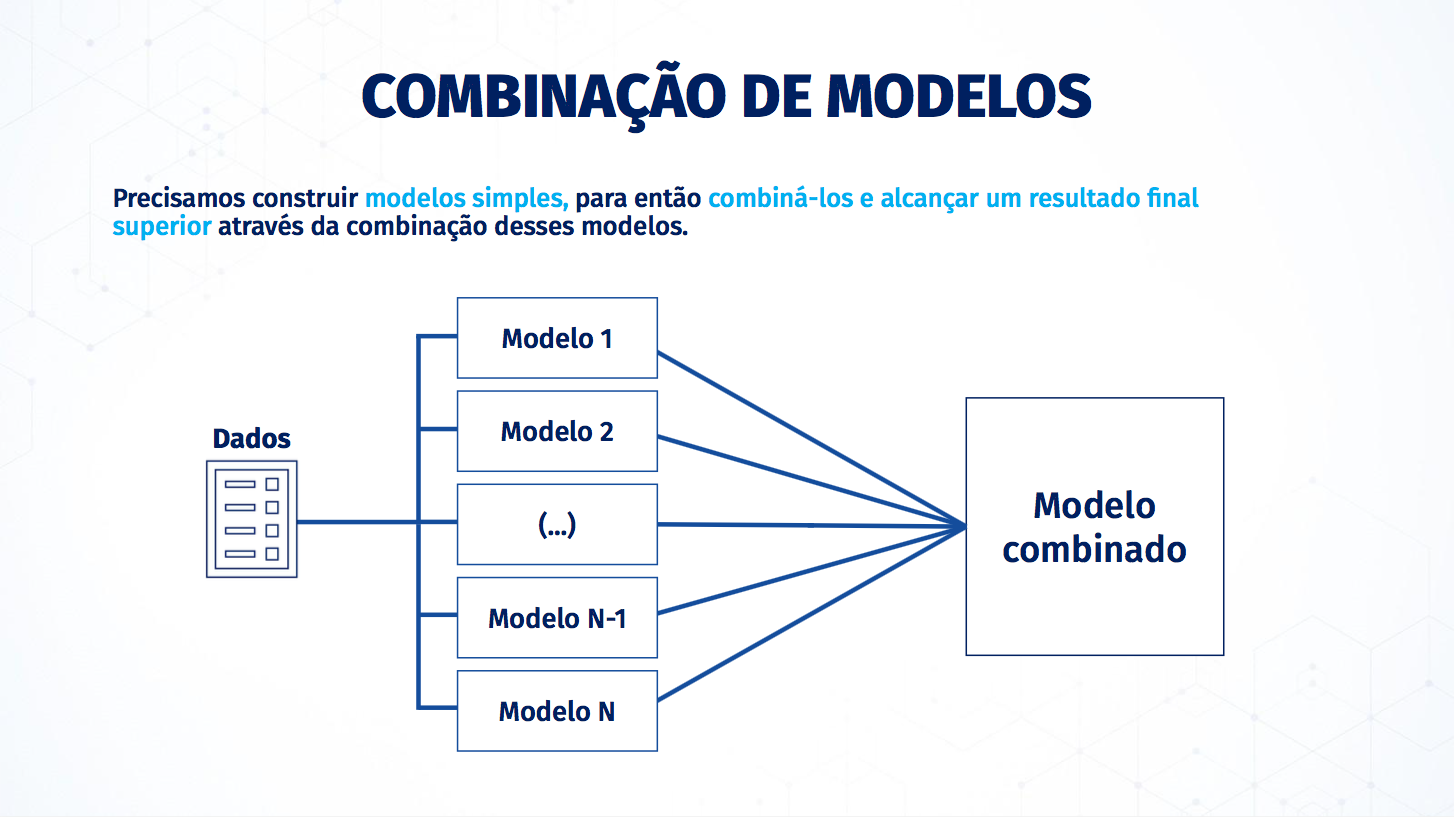



## Upgrade na Técnica de Validação: _K-FOLD REPETIDO_

O Método de _K-Fold_ va ser repetido. Isto é, sera feito varias vezes e se obtem a média. 

Lembrando:

Para a validação chamamos a biblioteca _sklearn.model_selection_ 

aplicando as funções:
   * _RepeatedKFold_ -> define repetições no K-Fold
   * _cross_validate_ -> a função que faz a validação cruzada e calcula a métrica.

n_splits: definição das partes no K-Fold

n_repeats : define quantas vezes será repetido o K-Fold

In [ ]:
# Configuração da Validação Cruzada

#from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

validacao = RepeatedKFold(n_splits = 10, n_repeats = 3)

###Fazendo os Modelos por separado

Será feita uma combinação entre os modelo: **Arvore de decisão** (com diferentes valores de profundidades), de **K-NN** (com diferentes valores de k) e de **Regressão Linear** é preferível criar uma função a qual vai chamar cada modelo com seus respectivos parâmetros. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
import numpy as np

**Para a Regressão Linear:**


In [ ]:
# Regressão Linear
reg = LinearRegression()
medidas = cross_val_score(reg, X, y, cv = validacao, scoring='neg_mean_squared_error')
#modelo.fit(Xtreino, ytreino)
#preditos = modelo.predict(Xteste)
#eqm = mean_squared_error(yteste, preditos) 
#round(medidas['neg_mean_squared_error'].mean(), 4)
#print('EQM : {}'.format(round(eqm, 4)))
print('EQM : {}'.format(round(medidas.mean()*(-1), 4)))

EQM : 50.4478


**Para K-NN:**

O resultado é obtido usando  k=25

In [ ]:
# KNN
knn = KNeighborsRegressor(n_neighbors = 25)
medidas = cross_val_score(knn, X, y, cv = validacao, scoring='neg_mean_squared_error')
#knn.fit(Xtreino, ytreino)
#preditos = knn.predict(Xteste)
#eqm = mean_squared_error(yteste, preditos) 
#print('EQM : {}'.format(round(eqm, 2)))
print('EQM : {}'.format(round(medidas.mean()*(-1), 4)))

EQM : 54.7416


**Para Árvore de Decesão:**

O resultado é obtido para uma profundidade de 3

In [ ]:
# Árvore de Decisão
arvore = DecisionTreeRegressor(max_depth = 3, min_samples_split = 150)
medidas = cross_val_score(arvore, X, y, cv = validacao, scoring='neg_mean_squared_error')
#arvore.fit(Xtreino, ytreino)
#preditos = arvore.predict(Xteste)
#eqm = mean_squared_error(yteste, preditos) 
#print('EQM : {}'.format(round(eqm, 2)))
print('EQM : {}'.format(round(medidas.mean()*(-1), 4)))

EQM : 35.1248


---
---


## **Combinação de Modelos**


Do modelos anteriores, feitos por separado, tinhamos que no máximo podemos alcançar um valor de **EQM** = 35 para o caso de **Árvore de Decisão**

Vamos utilizar a biblioteca _sklearn.ensemble_ que define as classificações

Também a função _VotingClassifier_ para fazer a combinação dos modelos.

Os modelos foram definidos e guardados em variáveis (tuplas: nome e modelo) **Reg. Logística**, **K-NN** par (k=25) e **Árvore** (profundidade=3)

Como resultado tivemos um valor de **EQM** = 39

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Combinação

from sklearn.ensemble import VotingRegressor
 
reglin = LinearRegression() 
knn = KNeighborsRegressor(n_neighbors = 25)
arvore = DecisionTreeRegressor(max_depth = 3)

# Criar tuplas  (Nome do modelo e o modelo)
modelos = [('Reg. Lin.', reglin),('KNN', knn),('Árvore', arvore)]

ensamble = VotingRegressor(modelos)
#ensamble = HoldoutRepetido(modelos)

medidas = cross_val_score(ensamble, X, y, cv = validacao, scoring='neg_mean_squared_error')
print('EQM : {}'.format(round(medidas.mean()*(-1), 4)))

EQM : 39.8368


**Fazendo a conta para varios modelos:**

In [ ]:
from collections import namedtuple
dados_modelo = namedtuple('dados_modelo',['nome','modelo'])
t1 = dados_modelo('Regressão Linear', LinearRegression()) 
tt1 = dados_modelo('KNN - K=5', KNeighborsRegressor(n_neighbors = 5))
tt2 = dados_modelo('KNN - K=15', KNeighborsRegressor(n_neighbors = 15))
tt3 = dados_modelo('KNN - K=25', KNeighborsRegressor(n_neighbors = 25))
tt4 = dados_modelo('KNN - K=35', KNeighborsRegressor(n_neighbors = 35))
ttt1 = dados_modelo('Árvore - Prof = 2', DecisionTreeRegressor(max_depth = 2))
ttt2 = dados_modelo('Árvore - Prof = 3', DecisionTreeRegressor(max_depth = 3))
ttt3 = dados_modelo('Árvore - Prof = 4', DecisionTreeRegressor(max_depth = 4))
ttt4 = dados_modelo('Árvore - Prof = 5', DecisionTreeRegressor(max_depth = 5))

In [ ]:
modu = [
        [t1,tt1,ttt1],[t1,tt1,ttt2],[t1,tt1,ttt3],[t1,tt1,ttt4],
        [t1,tt2,ttt1],[t1,tt2,ttt2],[t1,tt2,ttt3],[t1,tt2,ttt4],
        [t1,tt3,ttt1],[t1,tt3,ttt2],[t1,tt3,ttt3],[t1,tt3,ttt4],
        [t1,tt4,ttt1],[t1,tt4,ttt2],[t1,tt4,ttt3],[t1,tt4,ttt4],   
       ] 

eqms = []
indice = []
model1 = []
model2 = []
model3 = []      

In [ ]:
from sklearn.ensemble import VotingRegressor
i = 0
while i < len(modu):
  mod = VotingRegressor(modu[i])
  medidas = cross_val_score(mod, X, y, cv = validacao, scoring='neg_mean_squared_error')
  eqms.append(round(medidas.mean()*(-1), 4))
  #mod = HoldoutRepetido(modelos)
  #mod.fit(Xtreino, ytreino)
  #preditos_treino = mod.predict(Xtreino) 
  #treino = mean_squared_error(ytreino, preditos_treino)
  #treinos.append(treino) 
  #treinos.append(mod[0])   
  #testes.append(mod[1]) 

  indice.append(i+1)
  model1.append('Regressão Linear')
  m2=tt1.nome
  if i>3:
    m2=tt2.nome
    if i>7:
      m2=tt3.nome
      if i>11:
        m2=tt4.nome    
  model2.append(m2)
  if i==0 or i==4 or i==8 or i==12:
    m3=ttt1.nome
  if i==1 or i==5 or i==9 or i==13:
    m3=ttt2.nome    
  if i==2 or i==6 or i==10 or i==14:
    m3=ttt3.nome
  if i==3 or i==7 or i==11 or i==15:
    m3=ttt4.nome      
  model3.append(m3)
       
  i=i+1

aux = {'Modelo 1': model1,'Modelo 2': model2,'Modelo 3': model3,'EQM': eqms}
resultados = pd.DataFrame(aux,index = indice)
resultados.sort_values(by = 'EQM', ascending = True).round(4)

,Modelo 1,Modelo 2,Modelo 3,EQM
2,Regressão Linear,KNN - K=5,Árvore - Prof = 3,38.2600
1,Regressão Linear,KNN - K=5,Árvore - Prof = 2,38.2693
3,Regressão Linear,KNN - K=5,Árvore - Prof = 4,38.3935
6,Regressão Linear,KNN - K=15,Árvore - Prof = 3,38.6807
5,Regressão Linear,KNN - K=15,Árvore - Prof = 2,38.6934
4,Regressão Linear,KNN - K=5,Árvore - Prof = 5,38.7377
7,Regressão Linear,KNN - K=15,Árvore - Prof = 4,38.8595
8,Regressão Linear,KNN - K=15,Árvore - Prof = 5,39.1468
11,Regressão Linear,KNN - K=25,Árvore - Prof = 4,39.7959
10,Regressão Linear,KNN - K=25,Árvore - Prof = 3,39.8498


## Conclusão

Com a combinação dos modelos não tivemos uma melhora significativa, sendo que o melhor valor foi um **Eqm** = 38 para  um **KNN** = 5 e **Árvore** com profundidades = 2 - 5. 

A adição de uma variável (**Idade**) sem combinação de  modelos continua sendo melhor. 

Será feito o mesmo procedimento com a inclusão da variável **Idade** e verificar se esta nova variável melhora o resultado